### seq2seq
- seq2seq은 번역기에서 대표적으로 사용되는 모델이다. 앞으로 아래의 커다란 박스에서 점차적으로 확대하는 방식으로 해당 내용을 설명할 예정이다.
   
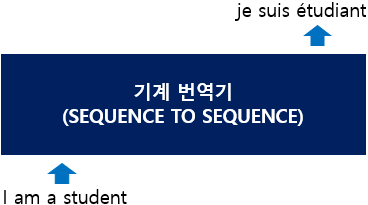
   
- seq2seq 모델 내부의 모습 : seq2seq은 크게 인코더와 디코더라는 두 개의 모듈로 구성된다. 인코더는 입력 문장의 모든 단어를 순차적으로 받은 뒤에 마지막에 모든 단어 정보들을 압축해서 하나의 벡터로 만드는데, 이를 컨텍스트 벡터(context vector)라고 한다. 입력 문장의 정보가 하나의 컨텍스트 벡터로 모두 압축되면 인코더는 컨텍스트 벡터를 디코더로 전송한다. 디코더는 컨텍스트 벡터를 받아서 단어를 한개씩 순차적으로 출력한다.
   
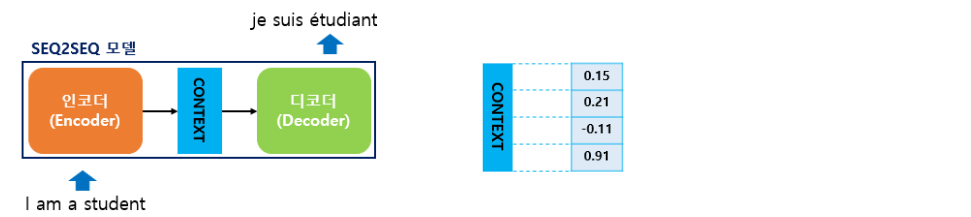
   
- 인코더와 디코더 내부 확대
   
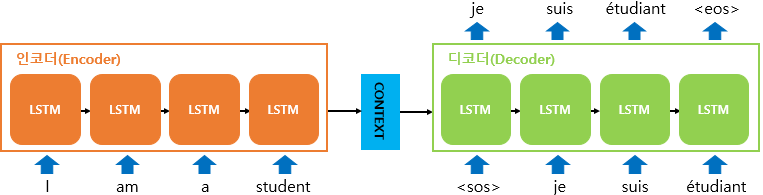
   
- 토큰이 있는 부분 확대
   
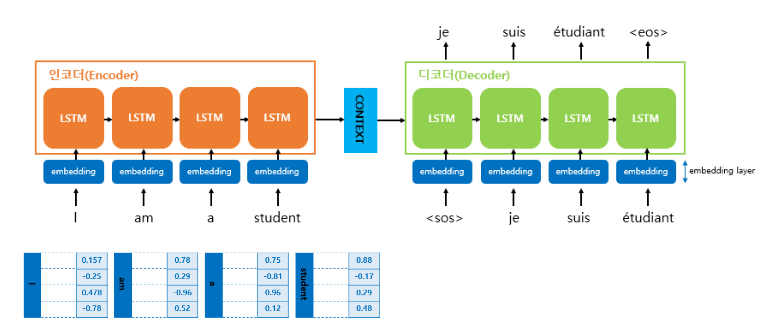
   
   기계는 텍스트보다 숫자를 잘 처리한다. 자연어처리에서 텍스트를 벡터로 바꾸는 방법으로 주로 워드 임베딩이 사용된다. 즉, 이 모델에서 사용되는 모든 단어들은 임베딩 벡터로 변환 후 입력으로 사용되는 셈이다. 
   
- 디코더 확대
   
   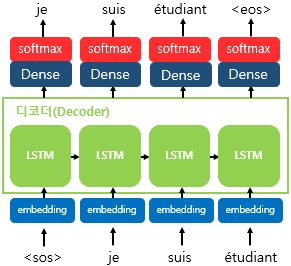
   
선택될 수 있는 모든 단어들로부터 하나의 단어를 골라서 예측한다. 이를 예측하기 위해서 소프트맥스 함수를 이용한다. 디코더에서는 각 시점의 RNN셀에서 출력 벡터가 나오면, 해당 벡터는 소프트 맥스 함수를 통해 출력 시퀀스의 각 단어별 확률값을 반환하고 디코더는 출력 단어를 결정한다.

In [1]:
# 번역기 만들기
# dataset : French-English(http://www.manythings.org/anki/)

import os
import shutil
import zipfile

import pandas as pd
import tensorflow as tf
import urllib3
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [6]:
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')
lines.sample(10)

,src,tar
5502,I'll be back.,\t \t Je reviens. \n \n
186133,"Do you know what I think? ""No, what?""","\t \t « Tu sais ce que je pense ? » « Non, quo..."
87434,Three of these are Tom's.,\t \t Il y en a trois à Tom. \n \n
93192,I thought it'd get easier.,\t \t Je pensais que ça deviendrait plus facil...
224521,Do you have any idea where Tom might have put ...,\t \t As-tu une idée de l'endroit où Tom aurai...
152722,I don't want you to get involved.,\t \t Je ne veux pas que tu t'en mêles. \n \n
210941,Tom shouldn't have dropped out of high school.,\t \t Tom n'aurait pas dû abandonner le lycée....
112789,I'm sorry if I wasn't clear.,\t \t Désolé si je n'ai pas été clair. \n \n
214821,"When I met Tom, he was dating a girl named Mary.","\t \t Quand j'ai rencontré Tom, il était avec ..."
170619,A cold wind was blowing on his face.,\t \t Un vent glacial lui soufflait sur le vis...


In [7]:
# 문자 집합 구축
src_vocab = set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 문자씩 읽음
        src_vocab.add(char)

tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print('source 문장의 char 집합 :',src_vocab_size)
print('target 문장의 char 집합 :',tar_vocab_size)

source 문장의 char 집합 : 91
target 문장의 char 집합 : 115


In [9]:
# 문자에 인덱스 부여
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, '+': 8, ',': 9, '-': 10, '.': 11, '/': 12, '0': 13, '1': 14, '2': 15, '3': 16, '4': 17, '5': 18, '6': 19, '7': 20, '8': 21, '9': 22, ':': 23, ';': 24, '?': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, 'a': 52, 'b': 53, 'c': 54, 'd': 55, 'e': 56, 'f': 57, 'g': 58, 'h': 59, 'i': 60, 'j': 61, 'k': 62, 'l': 63, 'm': 64, 'n': 65, 'o': 66, 'p': 67, 'q': 68, 'r': 69, 's': 70, 't': 71, 'u': 72, 'v': 73, 'w': 74, 'x': 75, 'y': 76, 'z': 77, '\xa0': 78, '\xad': 79, '°': 80, 'é': 81, 'ï': 82, 'ú': 83, 'ü': 84, '–': 85, '—': 86, '‘': 87, '’': 88, '₂': 89, '€': 90}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, 

In [10]:
encoder_input = []

# 1개의 문장
for line in lines.src:
  encoded_line = []
  # 각 줄에서 1개의 char
  for char in line:
    # 각 char을 정수로 변환
    encoded_line.append(src_to_index[char])
  encoder_input.append(encoded_line)
print('source 문장의 정수 인코딩 :',encoder_input[:5])

decoder_input = []
for line in lines.tar:
  encoded_line = []
  for char in line:
    encoded_line.append(tar_to_index[char])
  decoder_input.append(encoded_line)
print('target 문장의 정수 인코딩 :',decoder_input[:5])


source 문장의 정수 인코딩 : [[32, 66, 11], [32, 66, 11], [32, 66, 11], [32, 66, 11], [33, 60, 11]]
target 문장의 정수 인코딩 : [[1, 3, 1, 3, 51, 56, 3, 4, 3, 2, 3, 2], [1, 3, 1, 3, 42, 56, 73, 58, 63, 60, 15, 3, 2, 3, 2], [1, 3, 1, 3, 34, 69, 3, 73, 70, 76, 75, 60, 3, 4, 3, 2, 3, 2], [1, 3, 1, 3, 31, 70, 76, 62, 60, 3, 4, 3, 2, 3, 2], [1, 3, 1, 3, 48, 56, 67, 76, 75, 3, 4, 3, 2, 3, 2]]


In [14]:
decoder_target = []
for line in lines.tar:
  timestep = 0
  encoded_line = []
  for char in line:
    if timestep > 0:
      encoded_line.append(tar_to_index[char])
    timestep = timestep + 1
  decoder_target.append(encoded_line)
print('target 문장 레이블의 정수 인코딩 :',decoder_target[:5])

target 문장 레이블의 정수 인코딩 : [[3, 1, 3, 51, 56, 3, 4, 3, 2, 3, 2], [3, 1, 3, 42, 56, 73, 58, 63, 60, 15, 3, 2, 3, 2], [3, 1, 3, 34, 69, 3, 73, 70, 76, 75, 60, 3, 4, 3, 2, 3, 2], [3, 1, 3, 31, 70, 76, 62, 60, 3, 4, 3, 2, 3, 2], [3, 1, 3, 48, 56, 67, 76, 75, 3, 4, 3, 2, 3, 2]]


In [12]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

source 문장의 최대 길이 : 290
target 문장의 최대 길이 : 357


In [15]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

MemoryError: Unable to allocate 71.2 GiB for an array with shape (83086752, 115) and data type float64

In [16]:
# 데이터 전처리 완료 
# 모델 설계 시작

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)

# encoder_outputs은 여기서는 불필요
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 은닉 상태와 셀 상태.
encoder_states = [state_h, state_c]
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)

# 디코더에게 인코더의 은닉 상태, 셀 상태를 전달.
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=40, validation_split=0.2)
